In [1]:
import datetime
import os

from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.envs.pettingzoo import AECEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import format_data_multiagent, concatenate

from coltra import HomogeneousGroup, DAgent
from coltra.buffers import Observation
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer

from cogment_lab.actors.nn_actor import ColtraActor, RandomActor, ConstantActor

from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
# Cleans up potentially hanging background processes from previous runs
process_cleanup()

Processes terminated successfully.


In [3]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath)

logs/logs-2024-01-15T16:16:55.746880


In [4]:
cenv = GymEnvironment(
    env_id="LunarLander-v2",
    render=False,
)

await cog.run_env(env=cenv, 
                  env_name="lunar",
                  port=9011, 
                  log_file="env.log")


True

In [5]:
# Create a model using coltra

if os.path.exists("models/lunar"):
    agent = DAgent.load("models/lunar")
    model = agent.model
else:
    model = MLPModel(
        config={
        "hidden_sizes": [64, 64],
        }, 
        observation_space=cenv.env.observation_space, 
        action_space=cenv.env.action_space
    )

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

random_actor = RandomActor(cenv.env.action_space)
constant_actor = ConstantActor(0)

await cog.run_actor(actor=random_actor, 
                    actor_name="random", 
                    port=9022, 
                    log_file="actor-random.log")

await cog.run_actor(actor=constant_actor,
                    actor_name="constant",
                    port=9023,
                    log_file="actor-constant.log")

True

In [6]:
ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gae_lambda": 0.95,
    "minibatch_size": 128,
})

In [7]:
all_rewards = []

for t in (pbar := trange(100)):
    num_steps = 0
    episodes = []
    while num_steps < 1000:  # Collect at least 1000 steps per training iteration
        trial_id = await cog.start_trial(
            env_name="lunar",
            session_config={"render": False},
            actor_impls={
                "gym": "coltra",
            },
        )
        multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="lunar")
        data = multi_data["gym"]
        episodes.append(data)
        num_steps += len(data.rewards)
        
    all_data = concatenate(episodes)

    # Preprocess data
    record = convert_trial_data_to_coltra(all_data, actor.agent)

    # Run a PPO step
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")
    


mean_reward: -96.0: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it]   


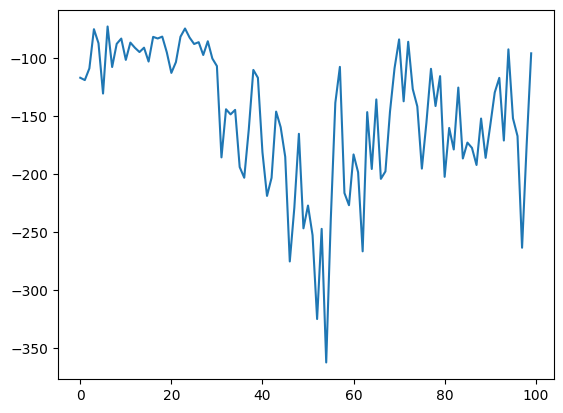

In [9]:
plt.plot(all_rewards)

In [10]:
cog.stop_service("lunar")

In [11]:
cenv = AECEnvironment(env_path="cogment_lab.envs.conversions.teacher.GymTeacherAEC",
                      make_kwargs={"gym_env_name": "LunarLander-v2", 
                                   "gym_make_kwargs": {}, 
                                   "render_mode": "rgb_array"},
                      render=True)

await cog.run_env(env=cenv, 
                  env_name="lunar-teach",
                  port=9011, 
                  log_file="env.log")

True

In [12]:
actions = {
    "no-op": {"active": 0, "action": 0},
    "ArrowDown": {"active": 1, "action": 0},
    "ArrowRight": {"active": 1, "action": 1},
    "ArrowUp": {"active": 1, "action": 2},
    "ArrowLeft": {"active": 1, "action": 3},
}

await cog.run_web_ui(actions=actions, log_file="human.log", fps=60)

True

In [13]:

trial_id = await cog.start_trial(
    env_name="lunar-teach",
    session_config={"render": True},
    actor_impls={
        "gym": "coltra",
        "teacher": "web_ui",
    },
)

data = await cog.get_trial_data(trial_id=trial_id)


In [14]:
data["gym"].rewards.sum()

-438.36224

In [15]:
await cog.cleanup()